In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import xskillscore as xs
import cartopy.crs as ccrs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import json
gcm = 'EC-Earth3'
import sys

2024-08-07 01:59:58.313306: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [67]:
sys.path.append(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')
from src.layers import *
from src.models import *
from src.gan import *
from ops.model_inference.src_eval_inference import *
os.chdir(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')

In [19]:
df_nobn = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty_nobn/{gcm}_Intensity_Penalty_nobn_hist_1986_2005_cascaded_perfect_applied.nc')
df_bn_ic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/{gcm}_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc')
df_tanh = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Tanh_Activation/{gcm}_hist_1986_2005_cascaded_perfect_applied.nc')
df_leaky = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/LeakyRelu_Activation/{gcm}_LeakyRelu_Activation_hist_1986_2005_cascaded_perfect_applied.nc')

In [68]:
df_nobn_normal_loss = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Constrained/{gcm}_IC_hist_2001_2014_10_perfect_framework_v2.nc')

In [69]:
df_nobn_noic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/No_Constraint/{gcm}_hist_2001_2014_10_perfect_framework_v2.nc')

In [70]:
con_av = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average/{gcm}_IC_AC_hist_2001_2014_10_perfect_framework_v2.nc')
ic_no_ens_mean = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average_No_Ensemble_Mean/{gcm}_IC_AC_hist_1985_2014_10_perfect_framework_v3.nc')
ec_earth3 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/EC-Earth3/{gcm}_IC_EC_hist_2001_2014_10_perfect_framework_v2.nc')

In [618]:
ic_no_ens_mean

<xarray.Dataset>
Dimensions:     (experiment: 4, member: 10, time: 10950, lat: 172, lon: 179)
Coordinates:
  * experiment  (experiment) float64 0.0 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'ACCESS-CM2'
  * time        (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [53]:
df_nobn_normal_loss.isel(member =0).pr.max(["lat","lon","time"])

<xarray.DataArray 'pr' (experiment: 7)>
array([   616.9547 ,    527.4447 ,    721.88214,   1660.8756 ,
         3883.7085 ,   4969.9805 , 106437.63   ], dtype=float32)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.0025 0.005 0.01 0.1
    GCM         <U10 'ACCESS-CM2'

In [16]:
gcm

'NorESM2-MM'

In [23]:
ground_truth = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
ground_truth['time'] = pd.to_datetime(ground_truth.time.dt.strftime("%Y-%m-%d"))
common_times = ground_truth.time.to_index().intersection(df_nobn_normal_loss.time.to_index())
with ProgressBar():
    ground_truth = ground_truth.sel(time = common_times).load()

In [24]:
import matplotlib.colors as mcolors
spatial_av = ground_truth.pr.mean(["lat","lon"]) * 86400
times_updated = spatial_av.where(spatial_av >16,np.nan).dropna("time").time[:-1]
times  = times_updated[0]#pd.to_datetime(['2004-01-16'])

In [25]:
times_updated

<xarray.DataArray 'time' (time: 2)>
array(['2002-02-27T00:00:00.000000000', '2005-06-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-02-27 2005-06-17
    GCM      <U9 'EC-Earth3'

In [54]:
times  = times_updated[1]#pd.to_datetime(['2004-01-16'])

In [60]:
times  = times_updated[1]#pd.to_datetime(['2004-01-16']).strftime("%Y-%m-%d")

In [26]:
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)

In [37]:
times_updated

<xarray.DataArray 'time' (time: 2)>
array(['2002-02-27T00:00:00.000000000', '2005-06-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-02-27 2005-06-17
    GCM      <U9 'EC-Earth3'

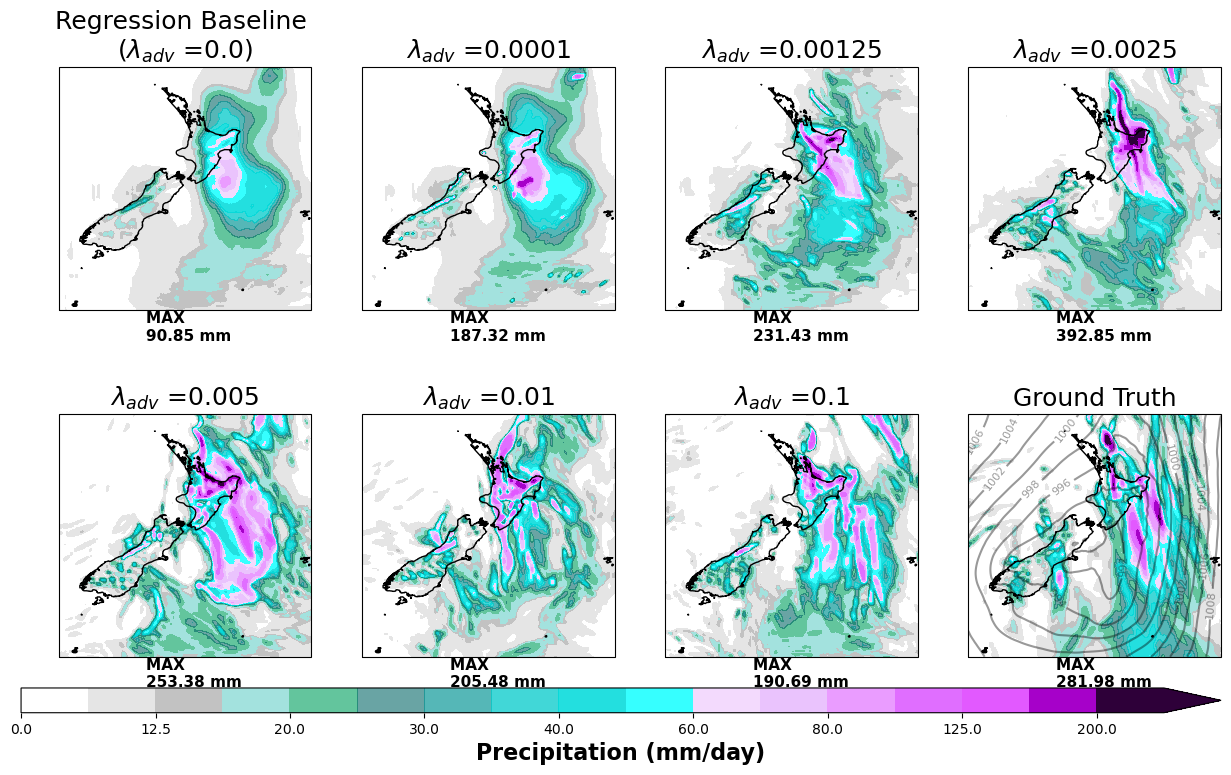

In [28]:



# Create the colormap using ListedColormap

# Define the norm with BoundaryNorm
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)
fig, ax = plt.subplots(2,4, figsize = (15, 8.25), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
ax = ax.ravel()
#ax = ax.T
levels = np.arange(0,7, 0.2)
for j in range(7):
    
    #ens_mean = dsets.sel(time =time).isel(experiment =j).mean("member")

    pressure_field_hpa = ground_truth.sel(time =times).psl/ 100
        #pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   #lon = slice(167, 180)).isel(experiment =j, member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        #mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =j, member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
    cs = df_nobn_normal_loss.sel(time =pd.to_datetime(times.values)).isel( experiment =j, member =4).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[j],
                                                                                                         add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
    max_intensity = df_nobn_normal_loss.sel(time =pd.to_datetime(times.values)).isel( experiment =j, member =4).max(["lat","lon"])
    mean_iten = df_nobn_normal_loss.sel(time =pd.to_datetime(times.values)).isel( experiment =j, member =4).mean(["lat","lon"])
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].coastlines('10m')

    ax[j].text(171.5, -53.5, f"MAX \n{'%.2f' % max_intensity.pr.values} mm", weight='bold',
    transform = ccrs.PlateCarree(), color ='k',
    fontsize =11)
                

     
        

        # Plot contours with a single color and labels every 5 hPa

    ax[j].set_title('')

    if j < 7:
        ax[j].set_title('$\lambda_{adv}$ =' + str(df_bn_ic.experiment.values[j]), fontsize =18)
    else:
        ax[j].set_title('Ground Truth', fontsize=18)
    if j ==0:
        ax[j].set_title('')
        ax[j].set_title('Regression Baseline \n($\lambda_{adv}$ =' + str(df_bn_ic.experiment.values[j])+")", fontsize =18)
    # if j ==0:
    #     ax[j].text(148, -43, f'{times.time.dt.strftime("%Y-%m-%d")}', weight ='bold', transform = ccrs.PlateCarree())
        

ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])

cs = (ground_truth.pr*86400).sel(time =pd.to_datetime(times.values)).plot.contourf( cmap = cmap, norm = norm, ax = ax[-1],
                                                                                                         add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
max_intensity =(ground_truth.pr*86400).sel(time =pd.to_datetime(times.values)).max(["lat","lon"])
ax[-1].text(171.5, -53.5, f"MAX \n{'%.2f' % max_intensity.values} mm", weight='bold',
transform = ccrs.PlateCarree(), color ='k',
fontsize =11)
                
contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 2), ax = ax[-1], transform = ccrs.PlateCarree(), alpha =0.4, zorder =15)
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%1.0f')
ax[-1].set_title('Ground Truth', fontsize=18)
cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
ax[-1].set_xlabel('')
ax[-1].set_ylabel('')
ax[-1].coastlines('10m')

# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 16, weight ='bold')
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Figure1_new_architecture_v2.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Figure1_new_architecture_v2.pdf', dpi =500, bbox_inches ='tight')

In [40]:
time = times_updated[0]

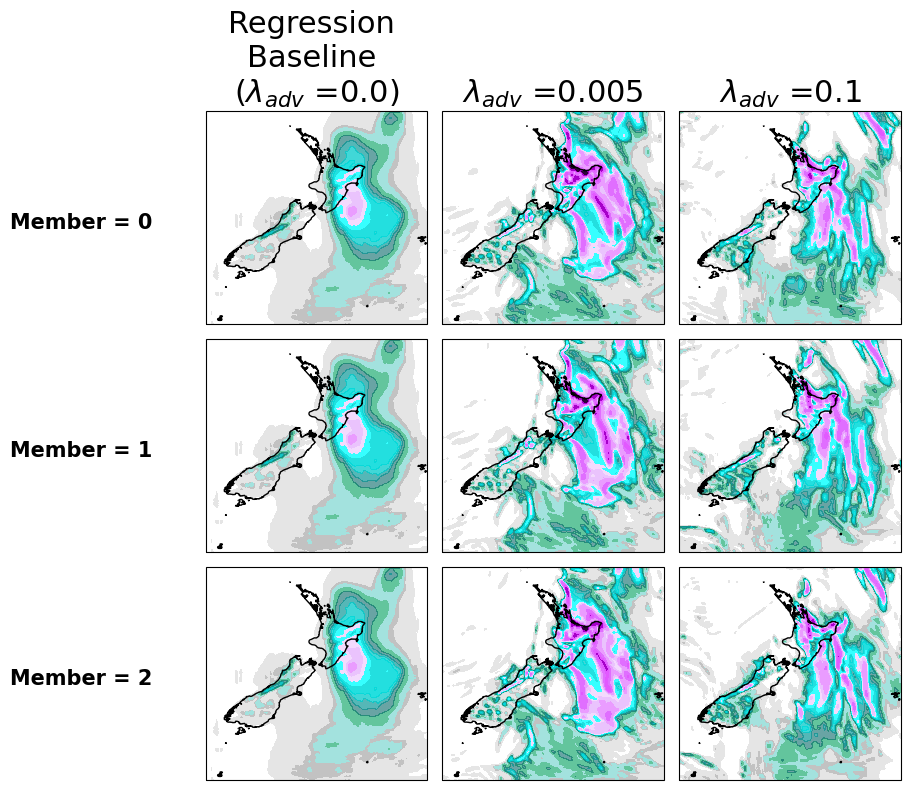

In [48]:

fig, ax = plt.subplots(3,3, figsize = (9, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
pressure_field_hpa = ground_truth.sel(time =times).psl/ 100
#ax = ax.T
lambdas = [0,4, -1]
levels = np.arange(0,7, 0.2)
for j in range(3):

    ens_mean =  df_nobn_normal_loss.sel(time =time).isel(experiment =lambdas[j]).mean("member")
    for i in range(3):

#         pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
#                                                                                                                    lon = slice(167, 180)).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - df_nobn_normal_loss.sel(time =time).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = df_nobn_normal_loss.sel(time =time).isel(member =i, experiment =lambdas[j]).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], 
                                                                                            add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        # contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
        # contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')

                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            ax[i,j].set_title('$\lambda_{adv}$ =' + str(df_nobn_normal_loss.experiment.values[lambdas[j]]), fontsize =22)
        if j ==0:
            ax[i,j].text(148, -43, f'Member = {i}', weight ='bold', transform = ccrs.PlateCarree(), fontsize =15)
        if (i ==0) & (j ==0):
            ax[i,j].set_title('Regression \nBaseline \n($\lambda_{adv}$ =' + str(df_nobn_normal_loss.experiment.values[lambdas[j]]) +")", fontsize =22)
        

#ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



#cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 18, weight ='bold')
fig.tight_layout()
#fig.tight_layout()
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Figure1_new_architecture_v2_ensembles.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/Figure1_new_architecture_v2_ensembles.pdf', dpi =500, bbox_inches ='tight')

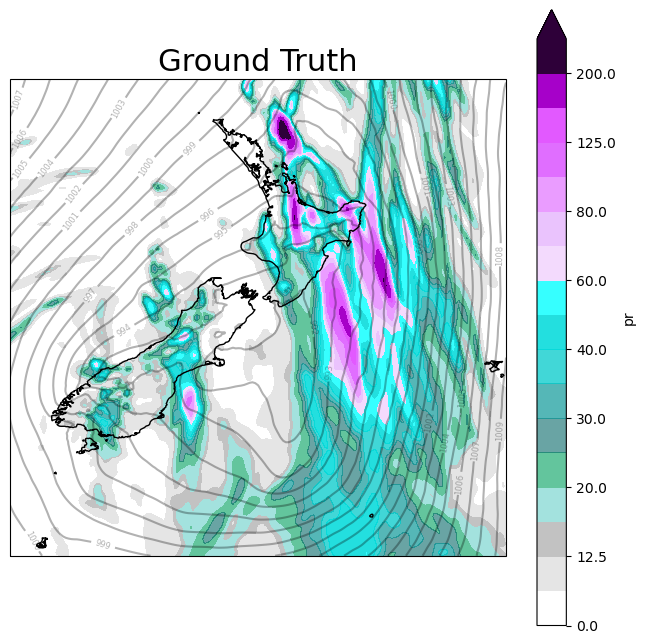

In [49]:
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)), figsize = (8,8))
time = times_updated[0]

(ground_truth.pr*86400).sel(time = time).plot.contourf( cmap = cmap, norm = norm, transform = ccrs.PlateCarree(), ax = ax, extend ='max')
ax.coastlines('10m')
contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax, transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')
ax.set_title('')
ax.set_title('Ground Truth', fontsize =22)
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/examples_of_dispersion_ground_truth_final.png', dpi =500, bbox_inches ='tight')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/examples_of_dispersion_ground_truth_final.pdf', dpi =500, bbox_inches ='tight')
 

In [65]:
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_dd

def psd(y, bins=np.arange(0, 0.52, 0.02)):
    """
    Compute Power Spectral Density (PSD) of an image y.

    Args:
    - y: Input image with shape (time, lat, lon).
    - bins: Array of bin edges for binning the wavenumbers.

    Returns:
    - psd_array: Array of PSD values with shape (time, K), where K is sqrt(kx^2 + ky^2),
                 representing the wavenumber in X and Y.

    - bin_edges: Bin edges used for binning the wavenumbers.
    """
    # Compute 2D FFT of the input image
    ffts = np.fft.fft2(y)
    ffts = np.fft.fftshift(abs(ffts) ** 2)

    # Compute the frequency grids
    freq = np.fft.fftshift(np.fft.fftfreq(172))
    freq2 = np.fft.fftshift(np.fft.fftfreq(179))
    kx, ky = np.meshgrid(freq, freq2)
    kx = kx.T
    ky = ky.T

    # Compute PSD by binning wavenumbers
    x = [
        binned_statistic(
            np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
            values=np.vstack(ffts[i].ravel()).T,
            statistic="mean",
            bins=bins,
        ).statistic
        for i in range(ffts.shape[0])
    ]

    # Compute PSD for the last time step (for normalization)
    x2 = binned_statistic(
        np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
        values=np.vstack(ffts[-1].ravel()).T,
        statistic="mean",
        bins=bins,
    )

    # Normalize the PSD and return it along with bin edges
    return np.array(x)[:, 0, :] / abs(x2.bin_edges[0] - x2.bin_edges[1]), x2.bin_edges

In [99]:
#df_nobn_noic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/No_Constraint/{gcm}_hist_2001_2014_10_perfect_framework_v2.nc')
df_nobn = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty_nobn/{gcm}_Intensity_Penalty_nobn_hist_1986_2005_cascaded_perfect_applied.nc')
df_bn_ic = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/{gcm}_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc')
df_tanh = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Tanh_Activation/{gcm}_hist_1986_2005_cascaded_perfect_applied.nc')
df_leaky = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/LeakyRelu_Activation/{gcm}_LeakyRelu_Activation_hist_1986_2005_cascaded_perfect_applied.nc')

In [108]:
y_exp = ground_truth.pr.sel(time = df_bn_ic.time.to_index().intersection(ground_truth.time.to_index())).expand_dims({"experiment":1}) *86400
y_exp['experiment'] = (('experiment'), ['Ground Truth'])
concat_dsets_cat = xr.concat([df_tanh.isel(member =0).pr.sel(time = y_exp.time), y_exp], dim ="experiment")
#concat_dsets_cat2 = xr.concat([dsets2, y.sel(time = dsets.time).expand_dims({"model":1})], dim ="model")

spatial_av = concat_dsets_cat.isel(experiment =-1).mean(["lat","lon"])
times = spatial_av.where(spatial_av >8,np.nan).dropna("time").time[:-1]

In [402]:
def compute_psd_averaged(df, ground_truth, timeslice):
    df = df.sel(time = timeslice)
    ground_truth_updated = ground_truth.sel(time = timeslice)
    y_exp = ground_truth_updated.pr.sel(time = df.time.to_index().intersection(ground_truth_updated.time.to_index())).expand_dims({"experiment":1}) *86400
    y_exp['experiment'] = (('experiment'), ['Ground Truth'])
    concat_dsets_cat = xr.concat([df.isel(member =0).pr.sel(time = y_exp.time), y_exp], dim ="experiment")
    #concat_dsets_cat2 = xr.concat([dsets2, y.sel(time = dsets.time).expand_dims({"model":1})], dim ="model")

    spatial_av = concat_dsets_cat.isel(experiment =-1).mean(["lat","lon"])
    times = spatial_av.where(spatial_av >5,np.nan).dropna("time").time[:-1]
    xs = []
    for i, lambda_var in enumerate(concat_dsets_cat.experiment.values):
        print(i)
        x1, y1 = psd((concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).values - concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).mean("time").values)/concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).std("time").values)
        xs.append(x1)
    return np.mean(np.array(xs), axis =1)

In [533]:
#psd_bn_ic_v35 = compute_psd_averaged(df_bn_ic, ground_truth, slice("2000","2005"))
#psd_bn_v35 = compute_psd_averaged(df_leaky, ground_truth, slice("2000","2005"))
psd_ic_noensmnea = compute_psd_averaged(ic_no_ens_mean, ground_truth, slice("2000","2005"))
psd_ec = compute_psd_averaged(ec_earth3, ground_truth, slice("2000","2005"))
psd_con_average = compute_psd_averaged(con_av, ground_truth, slice("2000","2005"))
# psd_bn_v15 = compute_psd_averaged(df_nobn_noic , ground_truth, slice("2000","2005"))
# psd_bn_ic_v15 = compute_psd_averaged(df_nobn_normal_loss , ground_truth, slice("2000","2005"))
# psd_ic_v35 = compute_psd_averaged(df_nobn , ground_truth, slice("2000","2005"))
# psd_bn_tanh = compute_psd_averaged(df_tanh, ground_truth, slice("2000","2005"))

0
1
2
3
4
0
1
2
3
4
0
1
2
3


In [542]:
psd_ic_noensmnea

array([[1.04500694e+09, 5.15592103e+07, 6.06709889e+06, 1.81978068e+06,
        8.16061329e+05, 4.43473010e+05, 2.75906815e+05, 1.60652899e+05,
        1.17688959e+05, 7.94975945e+04, 5.73949233e+04, 4.20574975e+04,
        3.11821520e+04, 2.95171682e+04, 1.95249793e+04, 2.00049541e+04,
        1.38247184e+04, 1.35024071e+04, 1.31413850e+04, 1.01038581e+04,
        1.11094469e+04, 8.09457152e+03, 1.02498511e+04, 7.33709125e+03,
        8.03521483e+03],
       [7.28082002e+08, 7.33431887e+07, 1.85491809e+07, 8.13383938e+06,
        4.26656419e+06, 2.58148004e+06, 1.71222129e+06, 1.14041980e+06,
        7.94453963e+05, 5.32096558e+05, 3.64917420e+05, 2.52611798e+05,
        1.70394756e+05, 1.19146277e+05, 8.01928466e+04, 5.86963787e+04,
        4.11766443e+04, 3.18283382e+04, 2.56422824e+04, 1.93626056e+04,
        1.79650003e+04, 1.40321794e+04, 1.41528666e+04, 1.13173790e+04,
        1.12785536e+04],
       [7.21106672e+08, 7.08630701e+07, 1.92145268e+07, 8.51692499e+06,
        4.6685

In [11]:
lams = [0.0, 0.0001, 0.00125, 0.0025, 0.005, 0.01, 0.1,-1]

In [543]:
con_av.experiment.values

array([0.    , 0.0025, 0.1   ])

In [544]:
d = {}
d['fft_bins'] = (('fft_bins'), y1[1:])
d['Lambda_adv'] = (('Lambda_adv'), lams)
d['Lambda_adv2'] = (('Lambda_adv2'), con_av.experiment.values.tolist() + [-1])
d['Lambda_adv3'] = (('Lambda_adv3'), ic_no_ens_mean.experiment.values.tolist() + [-1])
d['Lambda_adv4'] = (('Lambda_adv4'), ec_earth3.experiment.values.tolist() + [-1])
d['PSD BN IC 3.5M'] = (('Lambda_adv', 'fft_bins'), psd_bn_ic_v35)
d['PSD IC 3.5M'] = (('Lambda_adv', 'fft_bins'), psd_ic_v35)
d['PSD BN 3.5M'] = (('Lambda_adv', 'fft_bins'), psd_bn_v35)
d['PSD BN TANH 3.5M'] = (('Lambda_adv', 'fft_bins'), psd_bn_tanh)
d['PSD BN 1.5M'] = (('Lambda_adv', 'fft_bins'), psd_bn_v15)
d['PSD BN IC 1.5M'] = (('Lambda_adv', 'fft_bins'), psd_bn_ic_v15 )



d['PSD BN IC No ENS 1.5M'] = (('Lambda_adv3', 'fft_bins'), psd_ic_noensmnea)
d['PSD BN IC EC 1.5M'] = (('Lambda_adv4', 'fft_bins'), psd_ec)
d['PSD BN IC Max + Avg 1.5M'] = (('Lambda_adv2', 'fft_bins'), psd_con_average)

# Rerun the histograms for the others and then create the plots

In [545]:
dset = xr.Dataset(d)

In [546]:
dset.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_data_{gcm}_final.nc')

In [207]:
csv = pd.read_csv(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_data.csv')

In [411]:
dset

<xarray.Dataset>
Dimensions:           (fft_bins: 25, Lambda_adv: 8)
Coordinates:
  * fft_bins          (fft_bins) float64 0.02 0.04 0.06 0.08 ... 0.46 0.48 0.5
  * Lambda_adv        (Lambda_adv) float64 0.0 0.0001 0.00125 ... 0.01 0.1 -1.0
Data variables:
    PSD BN IC 3.5M    (Lambda_adv, fft_bins) float64 1.021e+09 ... 9.287e+03
    PSD IC 3.5M       (Lambda_adv, fft_bins) float64 1.024e+09 ... 9.287e+03
    PSD BN 3.5M       (Lambda_adv, fft_bins) float64 1.024e+09 ... 9.287e+03
    PSD BN TANH 3.5M  (Lambda_adv, fft_bins) float64 1.031e+09 ... 9.287e+03
    PSD BN 1.5M       (Lambda_adv, fft_bins) float64 1.051e+09 ... 9.287e+03
    PSD BN IC 1.5M    (Lambda_adv, fft_bins) float64 1.042e+09 ... 9.287e+03

In [547]:
def error(xs):
    z1=np.mean(np.array(xs)[:,:68], axis =1)
    error_icbn = np.sqrt((10 * np.log10(z1/(z1[-1]+0.0001))**2).mean(1))
    return error_icbn

In [548]:
error_set = np.sqrt(10 * np.log10(dset.isel(Lambda_adv =-1)/ (dset.isel(Lambda_adv =slice(0,-1))+0.0001))**2).mean("fft_bins")

In [550]:
error_set2= np.sqrt(10 * np.log10(dset.isel(Lambda_adv2 =-1)/ (dset.isel(Lambda_adv2 =slice(0,-1))+0.0001))**2).mean("fft_bins")
error_set3= np.sqrt(10 * np.log10(dset.isel(Lambda_adv3 =-1)/ (dset.isel(Lambda_adv3 =slice(0,-1))+0.0001))**2).mean("fft_bins")
error_set4= np.sqrt(10 * np.log10(dset.isel(Lambda_adv4 =-1)/ (dset.isel(Lambda_adv4 =slice(0,-1))+0.0001))**2).mean("fft_bins")

In [ ]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')
fig, ax = plt.subplots(figsize =(6,6))
plt.plot(concat_dsets_cat.experiment.values[:-1],error4[:-1], label ='Log PSD', color ='tab:blue')
plt.scatter(concat_dsets_cat.experiment.values[:-1], error4[:-1], color ='tab:blue', fc ='white', s=150)
plt.plot(concat_dsets_cat.experiment.values[:-1],error5[:-1], label ='PSD Normalized', color ='tab:orange')
plt.scatter(concat_dsets_cat.experiment.values[:-1],error5[:-1], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.plot(concat_dsets_cat.experiment.values[:-1],error6[:-1], label ='PSD', color ='r')
plt.scatter(concat_dsets_cat.experiment.values[:-1],error6[:-1],  color ='red', fc ='white', marker ='*', s=150)
plt.xscale('log')
ax.legend()
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('RALSD (dB)', fontsize =15)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/effect_of_psd_method_on_ralsd.png', dpi =300, bbox_inches ='tight')

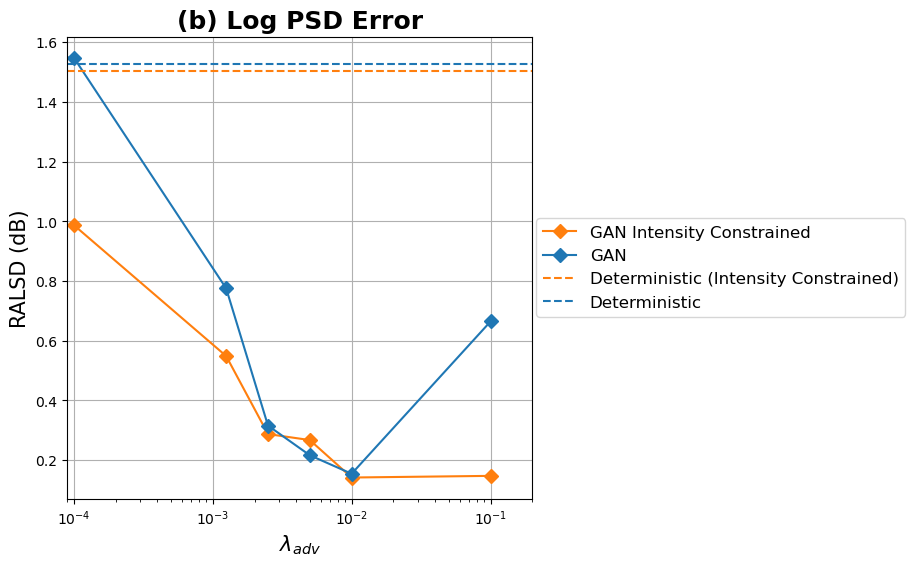

In [735]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
#ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN IC 3.5M'], label ='(i) GAN IC (Experiment 1)', color ='tab:blue', ls ='--', marker ='o', alpha =0.4, ms =6)
ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN IC 1.5M'], label ='GAN Intensity Constrained', color ='tab:orange',marker ='D', ms =7)
#ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], label ='(iii) GAN (Experiment 2)', color ='tab:orange', ls ='--', marker ='o', alpha =0.5, ms =6
#        )
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], label ='GAN', color ='tab:blue',marker ='D', ms =7)

#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')
#ax.axhline(error_set['PSD BN IC 3.5M'][0], color ='tab:blue', ls ='--', label = '(i) Deterministic', alpha =0.4)
ax.axhline(error_set['PSD BN IC 1.5M'][0], color ='tab:orange', ls ='--', label = 'Deterministic (Intensity Constrained)')
#ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:orange', ls ='--', label = '(iii) Deterministic', alpha =0.4)
ax.axhline(error_set['PSD BN 1.5M'][0], color ='tab:blue', ls ='--', label = 'Deterministic')

ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('RALSD (dB)', fontsize =15)
ax.legend(fontsize =12, loc ='center right', bbox_to_anchor = (1.82, 0.5))
ax.set_title('(b) Log PSD Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figure_final.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figure_final.pdf', dpi =700, bbox_inches ='tight')

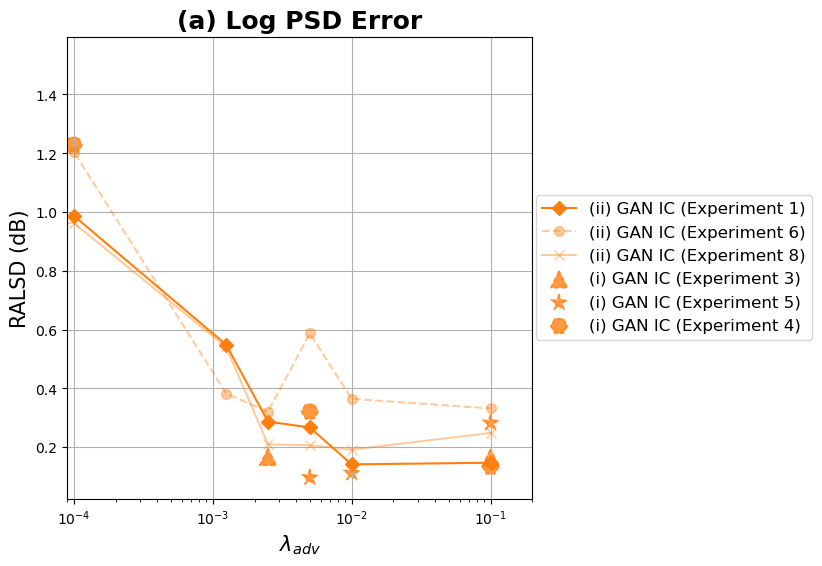

In [736]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
ax.scatter(error_set.Lambda_adv2.values[1:-1],error_set2['PSD BN IC Max + Avg 1.5M'][1:], label ='(i) GAN IC (Experiment 3)', color ='tab:orange', ls ='--', marker ='^', alpha =0.8, s=150)
ax.scatter(error_set.Lambda_adv3.values[1:-1],error_set3['PSD BN IC No ENS 1.5M'][1:], label ='(i) GAN IC (Experiment 5)', color ='tab:orange', ls ='--', marker ='*', alpha =0.8, s =150)
ax.scatter(error_set.Lambda_adv4.values[1:-1],error_set4['PSD BN IC EC 1.5M'][1:], label ='(i) GAN IC (Experiment 4)', color ='tab:orange', ls ='--', marker ='H', alpha =0.8, s =150)

ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN IC 1.5M'], label ='(ii) GAN IC (Experiment 1)', color ='tab:orange',marker ='D', ms =7, ls ='-')

ax.plot(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], label ='(ii) GAN IC (Experiment 6)', color ='tab:orange',marker ='o', ms =7, ls ='--', alpha =0.4)
ax.plot(concat_dsets_cat.experiment.values[:-1], error_set['PSD IC 3.5M'], label ='(ii) GAN IC (Experiment 8)', color ='tab:orange',marker ='x', ms =7, ls ='-', alpha =0.4)

#ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], label ='(iii) GAN (Experiment 2)', color ='tab:orange', ls ='--', marker ='o', alpha =0.5, ms =6
        #)
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
#ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], label ='(iv) GAN (Experiment 6)', color ='tab:orange',marker ='D', ms =7)

#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')
#ax.axhline(error_set['PSD BN IC 3.5M'][0], color ='tab:blue', ls ='--', label = '(i) Deterministic', alpha =0.4)
#ax.axhline(error_set['PSD BN IC 1.5M'][0], color ='tab:blue', ls ='--', label = '(ii) Deterministic')
#ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:orange', ls ='--', label = '(iii) Deterministic', alpha =0.4)
#ax.axhline(error_set['PSD BN 1.5M'][0], color ='tab:orange', ls ='--', label = '(iv) Deterministic')

ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('RALSD (dB)', fontsize =15)
ax.legend(fontsize =12, loc ='center right', bbox_to_anchor = (1.62, 0.5))
ax.set_title('(a) Log PSD Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figure_with_other_exp_incl.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figure_with_other_exp_incl.pdf', dpi =700, bbox_inches ='tight')

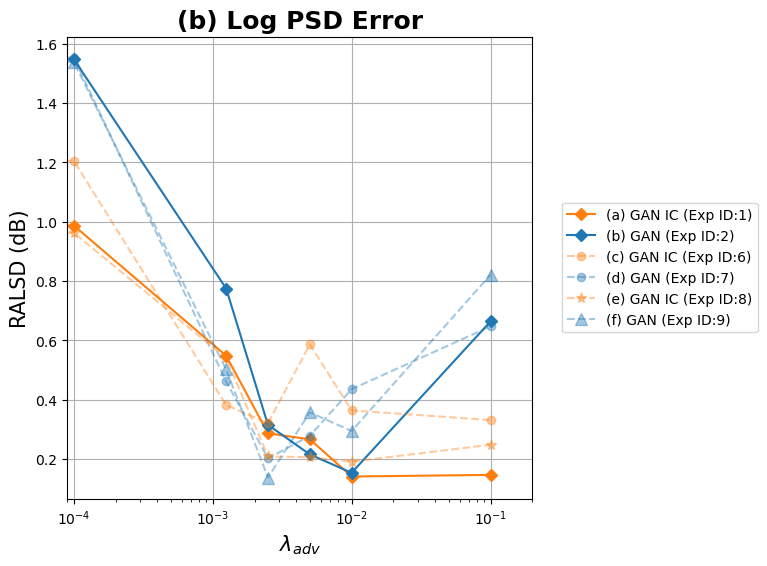

In [737]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN IC 1.5M'], label ='(a) GAN IC (Exp ID:1)', color ='tab:orange',marker ='D', ms =6)
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
ax.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], label ='(b) GAN (Exp ID:2)', color ='tab:blue',marker ='D', ms =6)
plt.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN IC 3.5M'], label ='(c) GAN IC (Exp ID:6)', color ='tab:orange', ls ='--', marker ='o', alpha =0.4, ms =6)
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)
plt.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], label ='(d) GAN (Exp ID:7)', color ='tab:blue', ls ='--', marker ='o', alpha =0.4, ms =6
       )


plt.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD IC 3.5M'], label ='(e) GAN IC (Exp ID:8)', color ='tab:orange', ls ='--', marker ='*', alpha =0.4, ms =8
       )
plt.plot(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN TANH 3.5M'], label ='(f) GAN (Exp ID:9)', color ='tab:blue', ls ='--', marker ='^', alpha =0.4, ms =8
       )
#plt.scatter(co
#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')

# ax.axhline(error_set['PSD BN 1.5M'][0], color ='tab:orange', ls ='--', label = '(a) Deterministic')
# ax.axhline(error_set['PSD BN IC 1.5M'][0], color ='tab:blue', ls ='--', label = '(b) Deterministic')
         
# ax.axhline(error_set['PSD BN IC 3.5M'][0], color ='tab:orange', ls ='--', label = '(c) Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(d) Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(e) Deterministic')
ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('RALSD (dB)', fontsize =15)
ax.legend(fontsize =10, loc ='center right', ncol =1, bbox_to_anchor =(1.5, 0.5))
ax.set_title('(b) Log PSD Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figurev2_full.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_log_error_figurev2_full.pdf', dpi =700, bbox_inches ='tight')

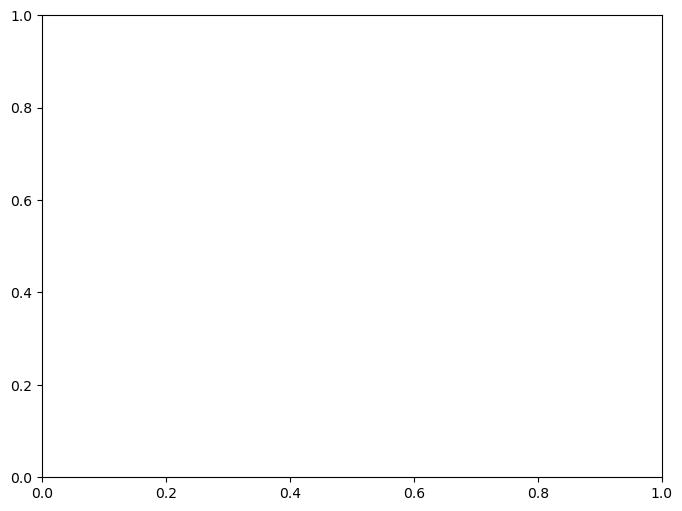

In [24]:
cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]

cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#fig, ax = plt.subplots(figsize = (8, 6))

In [727]:


# Define the colors representing "dry" and "wet"
def create_plot(concat_dset_cat, xs, y1, ax):
    minimum_freq_in_ccam = 12.5

    for i,lambdas_var in enumerate(concat_dsets_cat.experiment.values):
        if (lambdas_var == "Ground Truth")|(lambdas_var == -1):
            ax.loglog(y1[1:]/minimum_freq_in_ccam, xs[-1], color='k', lw=5, label='CCAM', ls ='--')
        else:
            # if i%2==0:
            # #color_str = "#{:02x}{:02x}{:02x}".format(*color_gradient[i])
            #     ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = cmap(i*50), ls ='--')
            ax.loglog(y1[1:]/minimum_freq_in_ccam, xs[i],label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[i], ls ='-', 
                      marker =marker_types[i], alpha =0.6, lw =2)

            #ax.axvline(max_values.sel(experiment = lambdas_var).pr.values, color  = color_str)
    reciprocal_ticks = [25, 50, 100, 500]

    # Compute frequency values from reciprocal values
    frequency_ticks = [1 / tick for tick in reciprocal_ticks]

    # Add vertical dashed lines at specified frequencies
    [ax.axvline(frequency_ticks[i], color='k', ls='--', alpha=0.3) for i in range(len(frequency_ticks))]

    # Add a legend
#     ax.legend(fontsize=12)

#     # Set the y-axis label and font properties
#     ax.set_ylabel('Power Spectral Density', weight='bold', fontsize=15)

#     # Set the x-axis label and font properties
#     ax.set_xlabel('Spatial Wavelength', weight='bold', fontsize=15)

    # Convert frequency_ticks to strings with the desired format
    frequency_labels = [f'$\\frac{{1}}{{{int(1/tick)}}}$ km' if int(1/tick) > 1 else '1 km' for tick in frequency_ticks]
    return ax, frequency_labels, frequency_ticks

#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/psd_plot_norm_intensity_constraint.png', dpi =500, bbox_inches ='tight')
# a

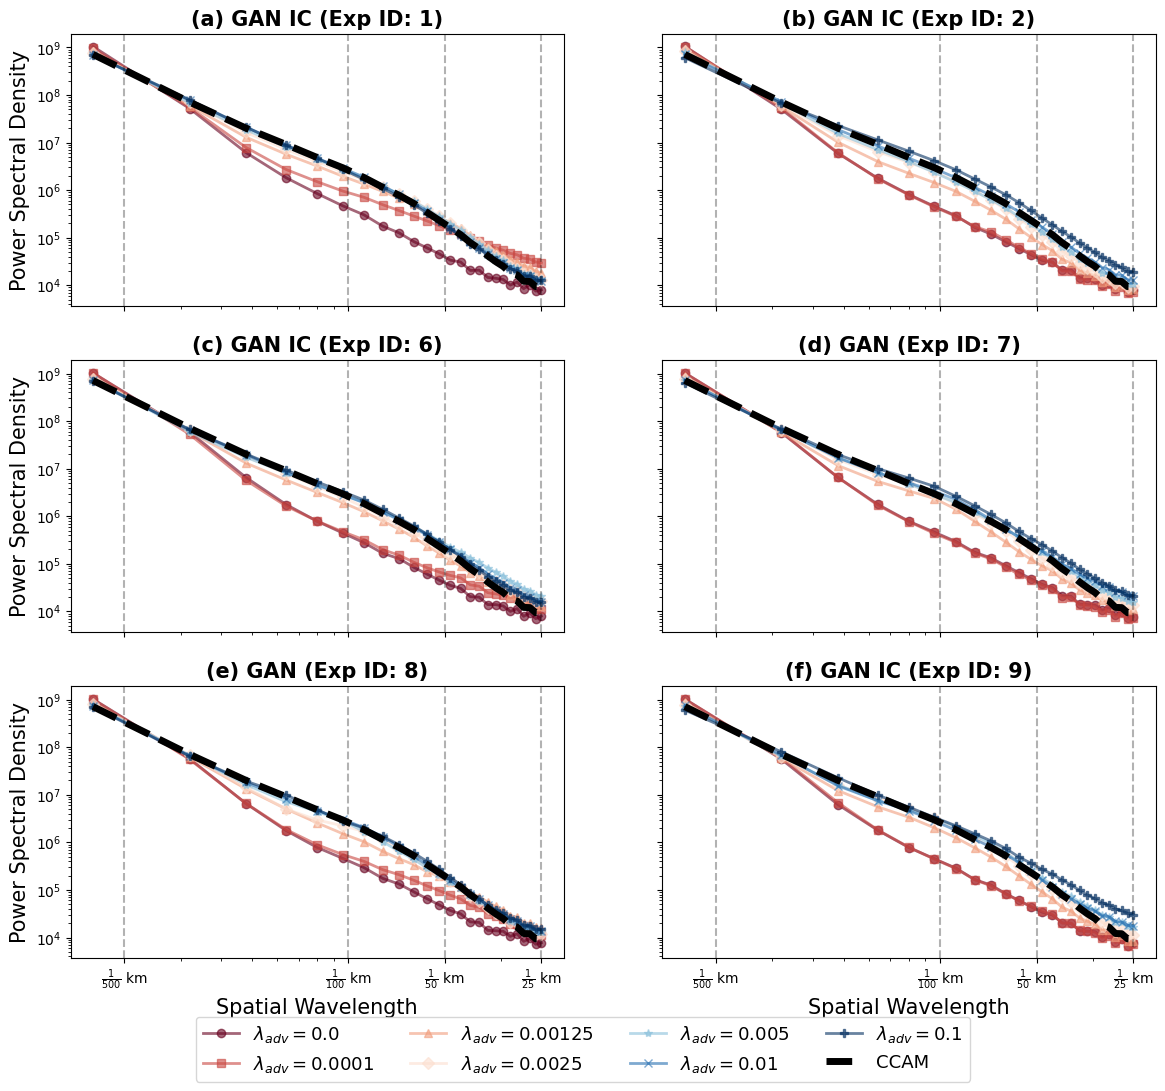

In [728]:
fig, ax = plt.subplots(3,2, figsize = (14, 12),sharex =True, sharey =True)
create_plot(concat_dsets_cat, dset['PSD BN 1.5M'], y1,ax[0,1])
create_plot(concat_dsets_cat, dset['PSD BN IC 1.5M'], y1,ax[0,0])
axes, labels, ticks = create_plot(concat_dsets_cat, dset['PSD BN IC 3.5M'], y1,ax[1,0])
create_plot(concat_dsets_cat, dset['PSD BN 3.5M'], y1,ax[1,1])
create_plot(concat_dsets_cat, dset['PSD IC 3.5M'], y1,ax[2,0])

create_plot(concat_dsets_cat, dset['PSD BN TANH 3.5M'], y1,ax[2,1])

ax[0,0].set_title('(a) GAN IC (Exp ID: 1)', fontsize =15, weight ='bold')
ax[0,1].set_title('(b) GAN IC (Exp ID: 2)', fontsize =15, weight ='bold')
ax[1,0].set_title('(c) GAN IC (Exp ID: 6)', fontsize =15, weight ='bold')
ax[1,1].set_title('(d) GAN (Exp ID: 7)', fontsize =15, weight ='bold')
ax[2,0].set_title('(e) GAN (Exp ID: 8)', fontsize =15, weight ='bold')
ax[2,1].set_title('(f) GAN IC (Exp ID: 9)', fontsize =15, weight ='bold')
#ax[2,0].xticks(labels, ticks)
plt.xticks(frequency_ticks, frequency_labels)
# Add any other desired labels, titles, legends, etc.
handles, labels = axes.get_legend_handles_labels()
ax[0,0].set_ylabel('Power Spectral Density', fontsize=15)
ax[1,0].set_ylabel('Power Spectral Density', fontsize=15)
ax[2,0].set_ylabel('Power Spectral Density', fontsize=15)
ax[2,0].set_xlabel('Spatial Wavelength', fontsize=15)
ax[2,1].set_xlabel('Spatial Wavelength', fontsize=15)
fig.legend(handles, labels, loc = 'lower center', ncol =4, fontsize =13)
# Show the plot
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_composites_full.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/psd/psd_composites_full.pdf', dpi =700, bbox_inches ='tight')
plt.show()

In [711]:
len(bins)


53

In [649]:
def updated_function(data, bins=None):
    # has shape time, lat, lon
    data = data.ravel()
    mask = np.where(data > 0.01)
    data = data[mask]
    
    return binned_statistic(x = data, values = data, statistic ='count', bins = bins)[0]

def load_gt(dset):
    ground_truth = xr.open_dataset(r"/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc").sel(GCM = gcm)
    ground_truth['time'] = pd.to_datetime(ground_truth.time.dt.strftime("%Y-%m-%d"))
    common_times = ground_truth.time.to_index().intersection(dset.time.to_index())[0:3650]
    with ProgressBar():
        ground_truth = ground_truth.sel(time = common_times).load()
    return ground_truth, dset.sel(time = common_times)
bins = np.arange(0,1050,20)
def compute_hist(df, ground_truth, timeslice, bins = bins):
    ground_truth_updated, df = load_gt(df)
    y_exp = ground_truth_updated.pr.sel(time = df.time.to_index().intersection(ground_truth_updated.time.to_index())).expand_dims({"experiment":1}) *86400
    y_exp['experiment'] = (('experiment'), ['Ground Truth'])
    concat_dsets_cat = xr.concat([df.isel(member =5).pr.sel(time = y_exp.time), y_exp], dim ="experiment")
    concat_dsets_cat = concat_dsets_cat.chunk({"experiment":1, "time":-1})
    #concat_dsets_cat2 = xr.concat([dsets2, y.sel(time = dsets.time).expand_dims({"model":1})], dim ="model")
    with ProgressBar():
        output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],
                            output_core_dims =[['bins']], output_sizes ={"bins":len(bins)-1}, vectorize = True, dask = 'parallelized', output_dtypes =[float], kwargs = dict(bins = bins)).compute()
        output['bins'] =(('bins'), bins[1:])
        
    return output

In [644]:
# con_av = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average/{gcm}_IC_AC_hist_2001_2014_10_perfect_framework_v2.nc')
# ic_no_ens_mean = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/Intensity_Con_Average_No_Ensemble_Mean/{gcm}_IC_AC_hist_1985_2014_10_perfect_framework_v3.nc')
# ec_earth3 = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/outputs/Reviewer/EC-Earth3/{gcm}_IC_EC_hist_2001_2014_10_perfect_framework_v2.nc')

In [650]:
hist_bn_ic_v35 = compute_hist(df_bn_ic, ground_truth, slice("2000","2005"))
hist_bn_v35 = compute_hist(df_leaky, ground_truth, slice("2000","2005"))
hist_bn_v15 = compute_hist(df_nobn_noic , ground_truth, slice("2000","2005"))
hist_bn_ic_v15 = compute_hist(df_nobn_normal_loss , ground_truth, slice("2000","2005"))
hist_ic_v35 = compute_hist(df_nobn , ground_truth, slice("2000","2005"))
hist_bn_tanh = compute_hist(df_tanh, ground_truth, slice("2000","2005"))
hist_ec_v15 = compute_hist(ec_earth3 , ground_truth, slice("2000","2005"))
hist_ic_no_ens_mean = compute_hist(ic_no_ens_mean, ground_truth, slice("2000","2005"))
hist_con_av = compute_hist(con_av , ground_truth, slice("2000","2005"))

[#############                           ] | 33% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed | 11.8s
[#############                           ] | 33% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed | 11.3s
[####################                    ] | 50% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed | 11.9s
[####################                    ] | 50% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  9.2s
[#############                           ] | 33% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  9.2s
[#############                           ] | 33% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  9.5s
[####################                    ] | 50% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  7.8s
[####################                    ] | 50% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  7.7s
[####################                    ] | 50% Completed |  0.1s

/tmp/ipykernel_375483/2502513611.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, concat_dsets_cat,input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed |  6.5s


In [651]:
hist_bn_tanh = hist_bn_tanh.to_dataset(name = 'Hist BN TANH 3.5M')
hist_ic_v35  = hist_ic_v35.to_dataset(name= 'Hist IC 3.5M')
hist_bn_ic_v15 = hist_bn_ic_v15.to_dataset(name = 'Hist BN IC 1.5M')
hist_bn_v15 = hist_bn_v15.to_dataset(name = 'Hist BN 1.5M')
hist_bn_v35 = hist_bn_v35.to_dataset(name = 'Hist BN 3.5M')
hist_bn_ic_v35 = hist_bn_ic_v35.to_dataset(name ='Hist BN IC 3.5M')

In [652]:
hist_ec_v15 = hist_ec_v15.to_dataset(name ='Hist EC BN IC 1.5M')
hist_ic_no_ens_mean = hist_ic_no_ens_mean.to_dataset(name ='Hist No ENS Mean BN IC 1.5M')
hist_con_av  = hist_con_av  .to_dataset(name ='Hist BN IC AC 1.5M')

In [681]:
merged_hist = xr.merge([hist_bn_tanh.drop("GCM") , hist_ic_v35.drop("GCM"), hist_bn_ic_v15.drop("GCM"), hist_bn_v15.drop("GCM") ,
                        hist_bn_v35.drop("GCM"), hist_bn_ic_v35.drop("GCM"),
                       hist_ec_v15, hist_ic_no_ens_mean, hist_con_av ])

In [71]:
merged_hist

<xarray.Dataset>
Dimensions:                      (experiment: 9, bins: 52)
Coordinates:
  * experiment                   (experiment) float64 0.0 0.0001 ... 0.1 -1.0
  * bins                         (bins) int64 20 40 60 80 ... 980 1000 1020 1040
    GCM                          (experiment) object 'ACCESS-CM2' ... 'EC-Ear...
Data variables:
    Hist BN TANH 3.5M            (experiment, bins) float64 1.107e+08 ... nan
    Hist IC 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 1.5M              (experiment, bins) float64 1.073e+08 ... nan
    Hist BN 1.5M                 (experiment, bins) float64 1.078e+08 ... nan
    Hist BN 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 3.5M              (experiment, bins) float64 1.107e+08 ... nan
    Hist EC BN IC 1.5M           (experiment, bins) float64 1.082e+08 ... nan
    Hist No ENS Mean BN IC 1.5M  (experiment, bins) float64 1.059e+08 ... nan
    Hist BN IC AC 1.5M           (experiment, bins) float64 1.075e+08 ... nan

In [654]:
merged_hist['experiment'] = [0.0, 0.0001, 0.001, 0.00125, 0.0025, 0.005, 0.01, 0.1, -1]

In [655]:
merged_hist.to_netcdf(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_{gcm}_FiNAL_10years.nc')

In [6]:
merged_hist = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_{gcm}_FiNAL_10years.nc')

In [8]:
merged_hist = merged_hist.where(merged_hist>=10, np.nan)

In [9]:
error_hist = np.sqrt((10 *np.log((merged_hist.isel(experiment =-1))/(merged_hist.isel(experiment =slice(0,-1))))**2).isel(bins = slice(0,-1)).mean("bins"))

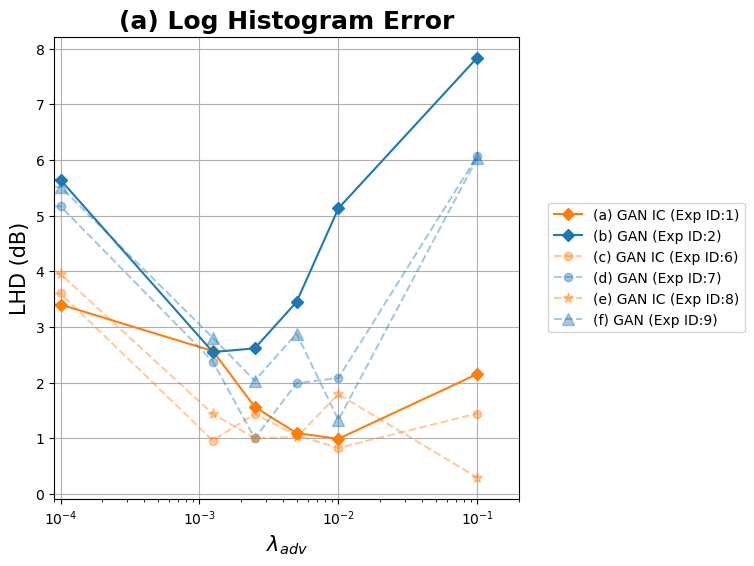

In [91]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
ax.plot(lams[:-1],error_hist ['Hist BN IC 1.5M'].dropna("experiment"), label ='(a) GAN IC (Exp ID:1)', color ='tab:orange',marker ='D', ms =6)
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
ax.plot(lams[:-1],error_hist ['Hist BN 1.5M'].dropna("experiment"), label ='(b) GAN (Exp ID:2)', color ='tab:blue',marker ='D', ms =6)
plt.plot(lams[:-1],error_hist ['Hist BN IC 3.5M'].dropna("experiment"), label ='(c) GAN IC (Exp ID:6)', color ='tab:orange', ls ='--', marker ='o', alpha =0.4, ms =6)
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)
plt.plot(lams[:-1],error_hist ['Hist BN 3.5M'].dropna("experiment"), label ='(d) GAN (Exp ID:7)', color ='tab:blue', ls ='--', marker ='o', alpha =0.4, ms =6
       )


plt.plot(lams[:-1],error_hist ['Hist IC 3.5M'].dropna("experiment"), label ='(e) GAN IC (Exp ID:8)', color ='tab:orange', ls ='--', marker ='*', alpha =0.4, ms =8
       )
plt.plot(lams[:-1],error_hist ['Hist BN TANH 3.5M'].dropna("experiment"), label ='(f) GAN (Exp ID:9)', color ='tab:blue', ls ='--', marker ='^', alpha =0.4, ms =8
       )
#plt.scatter(co
#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')

# ax.axhline(error_set['PSD BN 1.5M'][0], color ='tab:orange', ls ='--', label = '(a) Deterministic')
# ax.axhline(error_set['PSD BN IC 1.5M'][0], color ='tab:blue', ls ='--', label = '(b) Deterministic')
         
# ax.axhline(error_set['PSD BN IC 3.5M'][0], color ='tab:orange', ls ='--', label = '(c) Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(d) Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(e) Deterministic')
ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('LHD (dB)', fontsize =15)
ax.legend(fontsize =10, loc ='center right', ncol =1, bbox_to_anchor =(1.5, 0.5))
ax.set_title('(a) Log Histogram Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_updated.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_updated.pdf', dpi =700, bbox_inches ='tight')

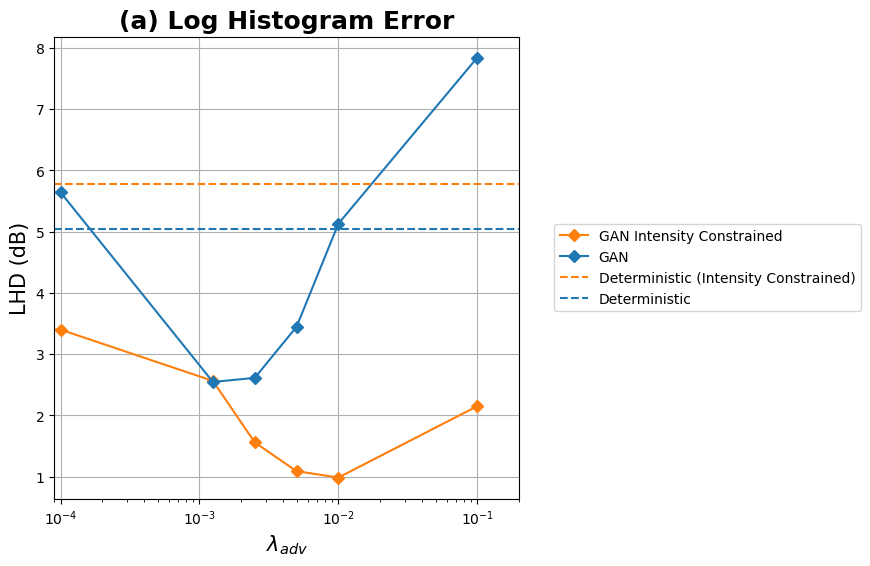

In [90]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
#plt.plot(lams[:-1],error_hist ['Hist BN IC 3.5M'].dropna("experiment"), label ='(i) GAN IC (Experiment 1)', color ='tab:blue', ls ='--', marker ='o', alpha =0.4, ms =6)
ax.plot(lams[:-1],error_hist ['Hist BN IC 1.5M'].dropna("experiment"), label ='GAN Intensity Constrained', color ='tab:orange',marker ='D', ms =6)
#plt.plot(lams[:-1],error_hist ['Hist BN 3.5M'].dropna("experiment"), label ='(iii) GAN (Experiment 2)', color ='tab:orange', ls ='--', marker ='o', alpha =0.4, ms =6
#       )
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
ax.plot(lams[:-1],error_hist ['Hist BN 1.5M'].dropna("experiment"), label ='GAN', color ='tab:blue',marker ='D', ms =6)

#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)



# plt.plot(lams[:-1],error_hist ['Hist IC 3.5M'].dropna("experiment"), label ='(e) GAN IC (Exp ID:3)', color ='tab:blue', ls ='--', marker ='*', alpha =0.4, ms =8
#        )
# plt.plot(lams[:-1],error_hist ['Hist BN TANH 3.5M'].dropna("experiment"), label ='(f) GAN (Exp ID:4)', color ='tab:orange', ls ='--', marker ='^', alpha =0.4, ms =8
#        )
#plt.scatter(co
#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')

#ax.axhline(error_hist['Hist BN IC 3.5M'][0], color ='tab:blue', ls ='--', label = '(i) Deterministic', alpha =0.4)
ax.axhline(error_hist['Hist BN IC 1.5M'][0], color ='tab:orange', ls ='--', label = 'Deterministic (Intensity Constrained)')
         
#ax.axhline(error_hist['Hist BN 3.5M'][0], color ='tab:orange', ls ='--', label = '(iii) Deterministic', alpha =0.4)
ax.axhline(error_hist['Hist BN 1.5M'][0], color ='tab:blue', ls ='--', label = 'Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(e) Deterministic')
ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('LHD (dB)', fontsize =15)
ax.legend(fontsize =10, loc ='center right', ncol =1, bbox_to_anchor =(1.75, 0.5))
ax.set_title('(a) Log Histogram Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v3_10_years.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v3_10_years.pdf', dpi =700, bbox_inches ='tight')

In [606]:
error_hist['Hist BN IC AC 1.5M']

<xarray.DataArray 'Hist BN IC AC 1.5M' (experiment: 8)>
array([5.81169275,        nan,        nan,        nan, 0.79033139,
              nan,        nan, 1.05173581])
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.001 0.00125 ... 0.005 0.01 0.1

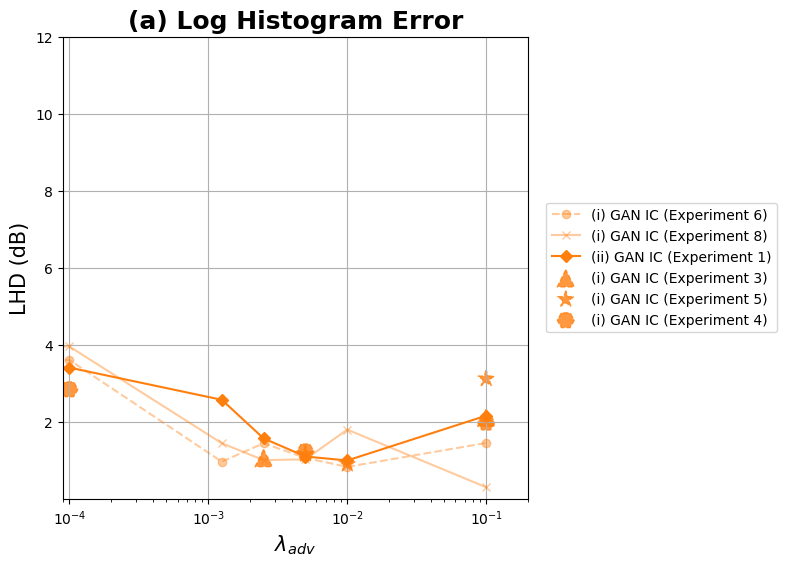

In [92]:
# plt.plot(error[:-1], marker ='o')
# plt.plot(error2[:-1], marker ='o')
#plt.plot(error3[:-1], marker ='o')
# plt.plot(error4[:-1], marker ='o')


fig, ax = plt.subplots(figsize =(6,6))

#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 3.5M'], color ='tab:orange', fc ='white', marker ='o', s=150)
plt.plot(lams[:-1],error_hist ['Hist BN IC 3.5M'].dropna("experiment"), label ='(i) GAN IC (Experiment 6)', color ='tab:orange', ls ='--', marker ='o', alpha =0.4, ms =6)
plt.plot(lams[:-1],error_hist ['Hist IC 3.5M'].dropna("experiment"), label ='(i) GAN IC (Experiment 8)', color ='tab:orange', ls ='-', marker ='x', alpha =0.4, ms =6)

ax.plot(lams[:-1],error_hist ['Hist BN IC 1.5M'].dropna("experiment"), label ='(ii) GAN IC (Experiment 1)', color ='tab:orange',marker ='D', ms =6)
#plt.plot(lams[:-1],error_hist ['Hist BN 3.5M'].dropna("experiment"), label ='(iii) GAN (Experiment 2)', color ='tab:orange', ls ='--', marker ='o', alpha =0.4, ms =6
#       )
#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 1.5M'], color ='tab:blue', fc ='white', s=150)
#ax.plot(lams[:-1],error_hist ['Hist BN 1.5M'].dropna("experiment"), label ='(iv) GAN (Experiment 6)', color ='tab:orange',marker ='D', ms =6)

#plt.scatter(concat_dsets_cat.experiment.values[:-1], error_set['PSD BN IC 3.5M'], color ='tab:blue', fc ='white', s=150)
ax.scatter(error_hist['Hist BN IC AC 1.5M'].dropna(dim="experiment").experiment.values,error_hist['Hist BN IC AC 1.5M'].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 3)', color ='tab:orange', ls ='--', marker ='^', alpha =0.8, s=150)
ax.scatter(error_hist['Hist No ENS Mean BN IC 1.5M'].dropna(dim="experiment").experiment.values,error_hist['Hist No ENS Mean BN IC 1.5M'].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 5)', color ='tab:orange', ls ='--', marker ='*', alpha =0.8, s =150)
ax.scatter(error_hist['Hist EC BN IC 1.5M'][:].dropna(dim="experiment").experiment.values,error_hist['Hist EC BN IC 1.5M'][:].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 4)', color ='tab:orange', ls ='--', marker ='H', alpha =0.8, s =150)

# hist_ec_v15 = hist_ec_v15.to_dataset(name ='Hist EC BN IC 1.5M')
# hist_ic_no_ens_mean = hist_ic_no_ens_mean.to_dataset(name ='Hist No ENS Mean BN IC 1.5M')
# hist_con_av  = hist_con_av  .to_dataset(name ='Hist BN IC AC 1.5M')
# plt.plot(lams[:-1],error_hist ['Hist IC 3.5M'].dropna("experiment"), label ='(e) GAN IC (Exp ID:3)', color ='tab:blue', ls ='--', marker ='*', alpha =0.4, ms =8
#        )
# plt.plot(lams[:-1],error_hist ['Hist BN TANH 3.5M'].dropna("experiment"), label ='(f) GAN (Exp ID:4)', color ='tab:orange', ls ='--', marker ='^', alpha =0.4, ms =8
#        )
#plt.scatter(co
#plt.scatter(concat_dsets_cat.experiment.values[:-1],error_set['PSD BN 1.5M'], color ='tab:orange', fc ='white', marker ='D', s=150)
plt.xscale('log')

#ax.axhline(error_hist['Hist BN IC 3.5M'][0], color ='tab:blue', ls ='--', label = '(i) Deterministic', alpha =0.4)
#ax.axhline(error_hist['Hist BN IC 1.5M'][0], color ='tab:blue', ls ='--', label = '(ii) Deterministic')
#         
#ax.axhline(error_hist['Hist BN 3.5M'][0], color ='tab:orange', ls ='--', label = '(iii) Deterministic', alpha =0.4)
#ax.axhline(error_hist['Hist BN 1.5M'][0], color ='tab:orange', ls ='--', label = '(iv) Deterministic')
# ax.axhline(error_set['PSD BN 3.5M'][0], color ='tab:blue', ls ='--', label = '(e) Deterministic')
ax.grid('on')
ax.set_xlim(0.9e-4, 2e-1)
ax.set_ylim(0.9e-4, 12)
ax.set_xlabel('$\lambda_{adv}$', fontsize =15)
ax.set_ylabel('LHD (dB)', fontsize =15)
ax.legend(fontsize =10, loc ='center right', ncol =1, bbox_to_anchor =(1.55, 0.5))
ax.set_title('(a) Log Histogram Error', fontsize =18, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v2_error_comparison_all_v2_10years.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v2_error_comparison_all_v2_10years.pdf', dpi =700, bbox_inches ='tight')

In [21]:
merged_hist

<xarray.Dataset>
Dimensions:                      (experiment: 9, bins: 52)
Coordinates:
  * experiment                   (experiment) float64 0.0 0.0001 ... 0.1 -1.0
  * bins                         (bins) int64 20 40 60 80 ... 980 1000 1020 1040
    GCM                          (experiment) object 'ACCESS-CM2' ... 'EC-Ear...
Data variables:
    Hist BN TANH 3.5M            (experiment, bins) float64 1.107e+08 ... nan
    Hist IC 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 1.5M              (experiment, bins) float64 1.073e+08 ... nan
    Hist BN 1.5M                 (experiment, bins) float64 1.078e+08 ... nan
    Hist BN 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 3.5M              (experiment, bins) float64 1.107e+08 ... nan
    Hist EC BN IC 1.5M           (experiment, bins) float64 1.082e+08 ... nan
    Hist No ENS Mean BN IC 1.5M  (experiment, bins) float64 1.059e+08 ... nan
    Hist BN IC AC 1.5M           (experiment, bins) float64 1.075e+08 ... nan

In [53]:
lams

[0.0, 0.0001, 0.00125, 0.0025, 0.005, 0.01, 0.1, -1]

In [72]:


# Define the colors representing "dry" and "wet"
def create_plot(concat_dset_cat, xs, y1, ax):
    minimum_freq_in_ccam = 12.5
    counter = 0
    for i,lambdas_var in enumerate(concat_dset_cat.experiment.values):
        #print(lambdas_var,counter)
        
        if (lambdas_var == "Ground Truth")|(lambdas_var == -1):
            ax.semilogy(y1[:], xs.isel(experiment = i), color='k', lw=5, label='CCAM', ls ='--')
        else:
            if (lambdas_var == 0.001):
                counter =2 
                
                ax.semilogy(y1[:], xs.isel(experiment = i),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[counter], ls ='-', 
                          marker =marker_types[counter], alpha =0.6, lw =2)
                counter+=1
            elif (lambdas_var == 0.00125):
                counter =2
                ax.semilogy(y1[:], xs.isel(experiment = i),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[counter], ls ='-', 
                          marker =marker_types[counter], alpha =0.6, lw =2)
                counter+=1
            else:
                ax.semilogy(y1[:], xs.isel(experiment = i),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[counter], ls ='-', 
                          marker =marker_types[counter], alpha =0.6, lw =2)
                counter+=1
                #ax.axvline(max_values.sel(experiment = lambdas_var).pr.values, color  = color_str)


    # Add a legend
#     ax.legend(fontsize=12)

#     # Set the y-axis label and font properties
#     ax.set_ylabel('Power Spectral Density', weight='bold', fontsize=15)

#     # Set the x-axis label and font properties
#     ax.set_xlabel('Spatial Wavelength', weight='bold', fontsize=15)

    # Convert frequency_ticks to strings with the desired format
    #frequency_labels = [f'$\\frac{{1}}{{{int(1/tick)}}}$ km' if int(1/tick) > 1 else '1 km' for tick in frequency_ticks]
    return ax#, frequency_labels, frequency_ticks

#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/psd_plot_norm_intensity_constraint.png', dpi =500, bbox_inches ='tight')
# a

In [74]:
merged_hist

<xarray.Dataset>
Dimensions:                      (experiment: 9, bins: 52)
Coordinates:
  * experiment                   (experiment) float64 0.0 0.0001 ... 0.1 -1.0
  * bins                         (bins) int64 20 40 60 80 ... 980 1000 1020 1040
    GCM                          (experiment) object 'ACCESS-CM2' ... 'EC-Ear...
Data variables:
    Hist BN TANH 3.5M            (experiment, bins) float64 1.107e+08 ... nan
    Hist IC 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 1.5M              (experiment, bins) float64 1.073e+08 ... nan
    Hist BN 1.5M                 (experiment, bins) float64 1.078e+08 ... nan
    Hist BN 3.5M                 (experiment, bins) float64 1.107e+08 ... nan
    Hist BN IC 3.5M              (experiment, bins) float64 1.107e+08 ... nan
    Hist EC BN IC 1.5M           (experiment, bins) float64 1.082e+08 ... nan
    Hist No ENS Mean BN IC 1.5M  (experiment, bins) float64 1.059e+08 ... nan
    Hist BN IC AC 1.5M           (experiment, bins) float64 1.075e+08 ... nan

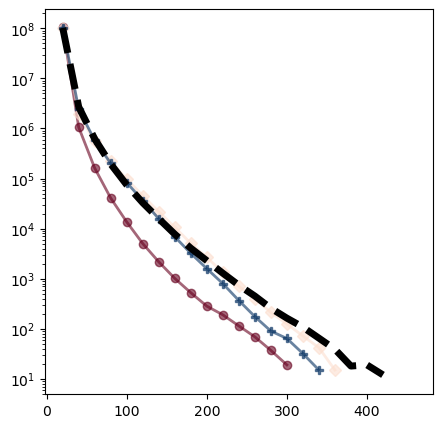

In [83]:
fig, ax = plt.subplots( figsize = (5, 5))
create_plot(merged_hist, merged_hist['Hist BN IC AC 1.5M'], bins,ax)

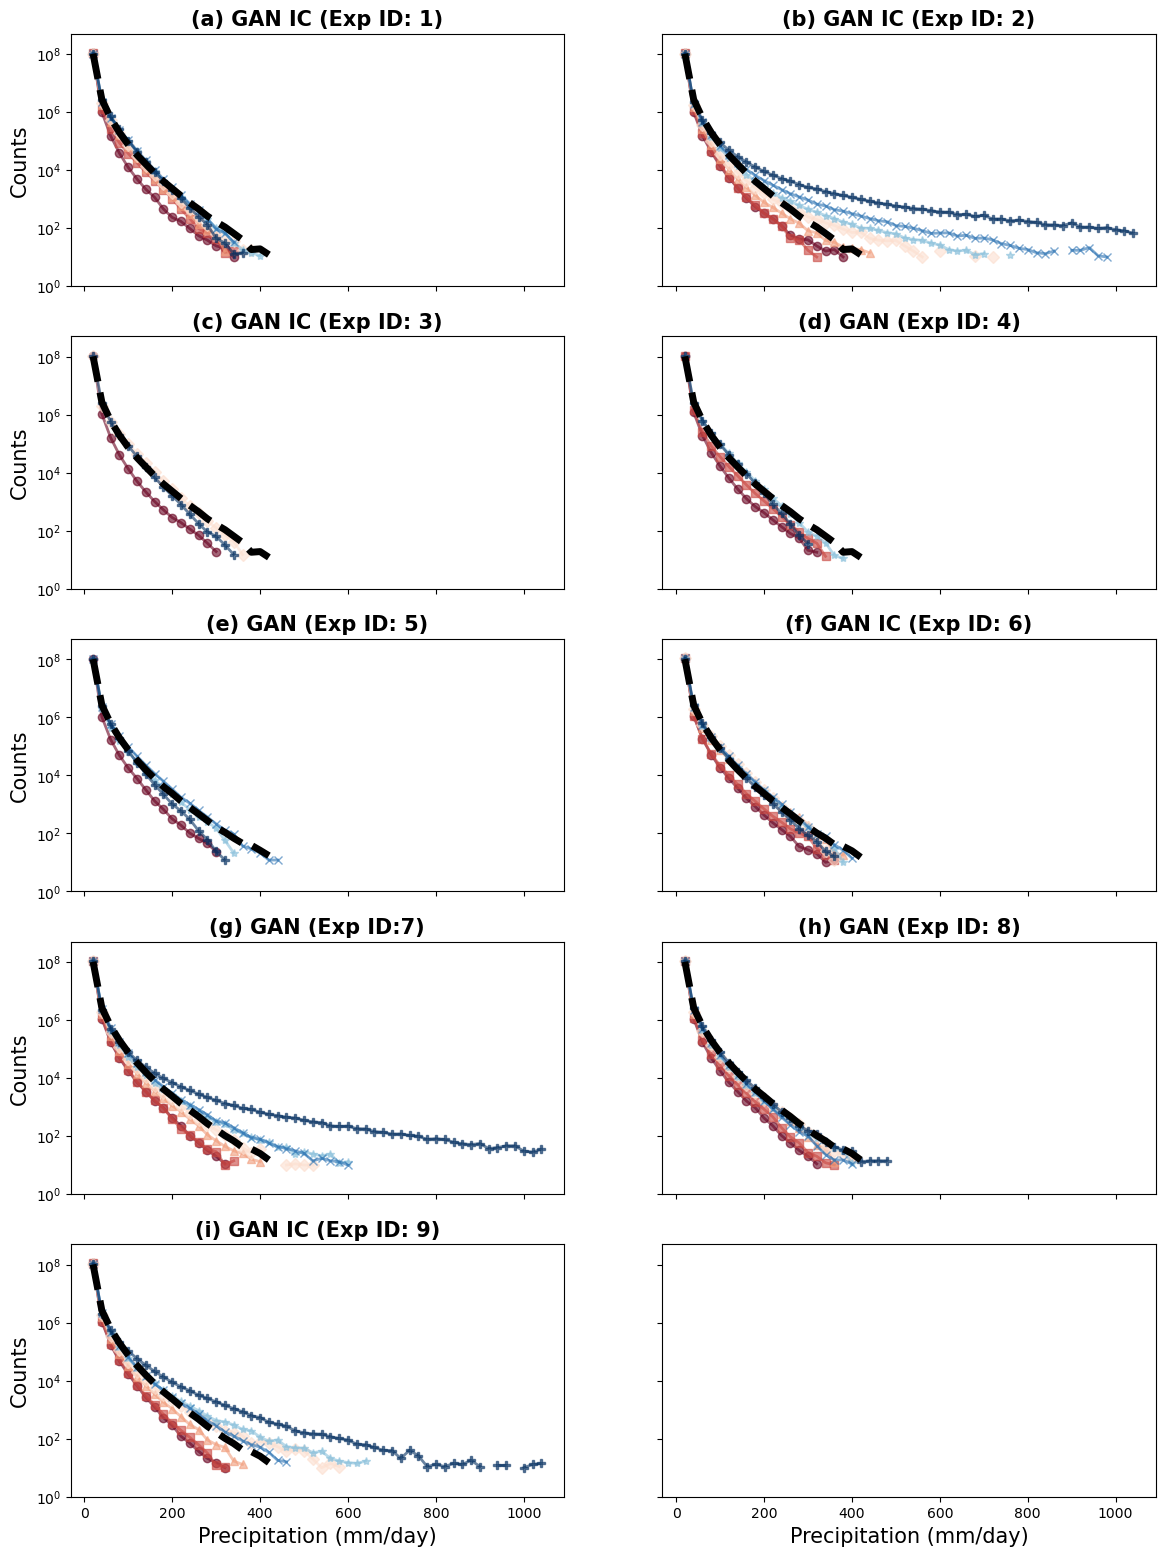

In [89]:
fig, ax = plt.subplots(5,2, figsize = (14, 19),sharex =True, sharey =True)
bins = merged_hist.bins

#create_plot(merged_hist,  merged_hist['Hist BN TANH 3.5M'], bins,ax[1,1])
#create_plot(merged_hist, merged_hist['Hist BN 1.5M'], bins,ax[2,0])


create_plot(merged_hist, merged_hist['Hist BN IC 1.5M'], bins,ax[0,0])
create_plot(merged_hist, merged_hist['Hist BN 1.5M'], bins,ax[0,1])
create_plot(merged_hist, merged_hist['Hist BN IC AC 1.5M'], bins,ax[1,0])
create_plot(merged_hist, merged_hist['Hist EC BN IC 1.5M'], bins,ax[1,1])
create_plot(merged_hist, merged_hist['Hist No ENS Mean BN IC 1.5M'], bins,ax[2,0])
create_plot(merged_hist,  merged_hist['Hist BN IC 3.5M'], bins,ax[2,1])
create_plot(merged_hist,  merged_hist['Hist BN 3.5M'], bins,ax[3,0])
create_plot(merged_hist,  merged_hist['Hist IC 3.5M'], bins,ax[3,1])
create_plot(merged_hist,  merged_hist['Hist BN TANH 3.5M'], bins,ax[4,0])
#ax.scatter(error_hist['Hist BN IC AC 1.5M'].dropna(dim="experiment").experiment.values,error_hist['Hist BN IC AC 1.5M'].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 7)', color ='tab:blue', ls ='--', marker ='^', alpha =0.8, s=150)
#ax.scatter(error_hist['Hist No ENS Mean BN IC 1.5M'].dropna(dim="experiment").experiment.values,error_hist['Hist No ENS Mean BN IC 1.5M'].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 9)', color ='tab:blue', ls ='--', marker ='*', alpha =0.8, s =150)
#ax.scatter(error_hist['Hist EC BN IC 1.5M'][:].dropna(dim="experiment").experiment.values,error_hist['Hist EC BN IC 1.5M'][:].dropna(dim="experiment"), label ='(i) GAN IC (Experiment 8)', color ='tab:blue', ls ='--', marker ='H', alpha =0.8, s =150)





ax[0,0].set_title('(a) GAN IC (Exp ID: 1)', fontsize =15, weight ='bold')
ax[0,1].set_title('(b) GAN IC (Exp ID: 2)', fontsize =15, weight ='bold')
ax[1,0].set_title('(c) GAN IC (Exp ID: 3)', fontsize =15, weight ='bold')
ax[1,1].set_title('(d) GAN (Exp ID: 4)', fontsize =15, weight ='bold')
ax[2,0].set_title('(e) GAN (Exp ID: 5)', fontsize =15, weight ='bold')
ax[2,1].set_title('(f) GAN IC (Exp ID: 6)', fontsize =15, weight ='bold')
ax[3,0].set_title('(g) GAN (Exp ID:7)', fontsize =15, weight ='bold')
ax[3,1].set_title('(h) GAN (Exp ID: 8)', fontsize =15, weight ='bold')
ax[4,0].set_title('(i) GAN IC (Exp ID: 9)', fontsize =15, weight ='bold')
#ax[2,0].xticks(labels, ticks)
#plt.xticks(frequency_ticks, frequency_labels)
# Add any other desired labels, titles, legends, etc.
#axes= create_plot(merged_hist, merged_hist['Hist BN IC 3.5M'], bins,ax[0,0])
handles, labels = axes.get_legend_handles_labels()
ax[0,0].set_ylabel('Counts', fontsize=15)
ax[1,0].set_ylabel('Counts', fontsize=15)
ax[2,0].set_ylabel('Counts', fontsize=15)
ax[3,0].set_ylabel('Counts', fontsize=15)
ax[4,0].set_ylabel('Counts', fontsize=15)
ax[4,0].set_xlabel('Precipitation (mm/day)', fontsize=15)
ax[4,1].set_xlabel('Precipitation (mm/day)', fontsize=15)
#fig.legend(handles, labels, loc = 'lower center', ncol =4, fontsize =13)
ax[0,0].set_ylim(1e0, 5e8)
# Show the plot
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v2_all_final_v2_10_years.png', dpi =700, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/intermediate_outputs/histogram/histogram_distance_v2_all_v2_10_years.pdf', dpi =700, bbox_inches ='tight')
plt.show()

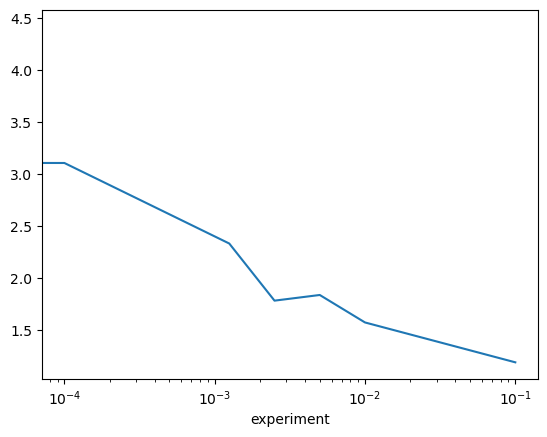

In [388]:
np.sqrt((10 *np.log((hist_bn_ic_v35.isel(experiment =-1))/(hist_bn_ic_v35.isel(experiment =slice(0,-1))))**2).mean("bins")).to_pandas().plot()
plt.xscale('log')

In [343]:
df_bn_ic = df_bn_ic.chunk({"experiment":1})

In [354]:
with ProgressBar():
    output = xr.apply_ufunc(updated_function, df_bn_ic.isel( member =0), input_core_dims =[['time','lat','lon']],
                            output_core_dims =[['bins']], output_sizes ={"bins":33}, vectorize = True, dask = 'parallelized', output_dtypes =[float]).compute()

[                                        ] | 0% Completed |  0.1s

/tmp/ipykernel_375483/3196182493.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output = xr.apply_ufunc(updated_function, df_bn_ic.isel( member =0), input_core_dims =[['time','lat','lon']],


[########################################] | 100% Completed | 16.2s


In [355]:
output

<xarray.Dataset>
Dimensions:     (experiment: 7, bins: 33)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.00125 0.0025 0.005 0.01 0.1
Dimensions without coordinates: bins
Data variables:
    pr          (experiment, bins) float64 2.23e+08 9.817e+05 ... 0.0 0.0

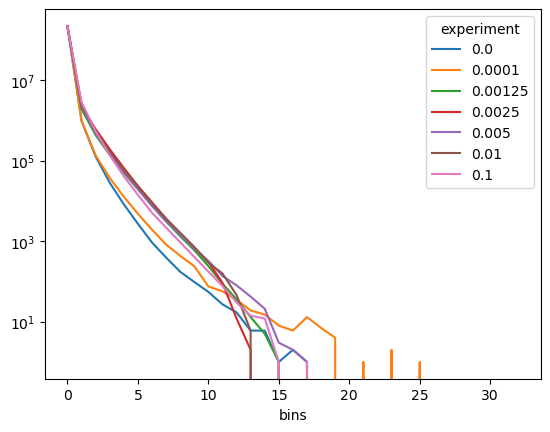

In [342]:
output.pr.to_pandas().T.plot()
plt.yscale('log')

In [326]:
from scipy.stats import binned_statistic


In [ ]:
psd_bn_ic_v35 = compute_psd_averaged(df_bn_ic, ground_truth, slice("2000","2005"))
psd_bn_v35 = compute_psd_averaged(df_leaky, ground_truth, slice("2000","2005"))
psd_bn_v15 = compute_psd_averaged(df_nobn_noic , ground_truth, slice("2000","2005"))
psd_bn_ic_v15 = compute_psd_averaged(df_nobn_normal_loss , ground_truth, slice("2000","2005"))
psd_ic_v35 = compute_psd_averaged(df_nobn , ground_truth, slice("2000","2005"))
psd_bn_tanh = compute_psd_averaged(df_tanh, ground_truth, slice("2000","2005"))